In [12]:
using Pkg

# Activate local project environment
Pkg.activate("/g/data/v46/txs156/ClimaOcean.jl/")

# Add the global environment to the package search path
push!(LOAD_PATH, "/g/data/e14/txs156/.julia/environments/v1.10/")

using CairoMakie, IJulia, JLD2  # From global
using Oceananigans  # From local
using Statistics


  Activating project at `/g/data/v46/txs156/ClimaOcean.jl`


In [13]:
experiment_path = "/g/data/v46/txs156/ClimaOcean.jl-checkpointer/examples/"

"/g/data/v46/txs156/ClimaOcean.jl-checkpointer/examples/"

In [14]:
u_surf_checkpoint = FieldTimeSeries(experiment_path*"checkpointer_mwe_surface.jld2", "u"; backend = OnDisk())
v_surf_checkpoint = FieldTimeSeries(experiment_path*"checkpointer_mwe_surface.jld2", "v"; backend = OnDisk())
T_surf_checkpoint = FieldTimeSeries(experiment_path*"checkpointer_mwe_surface.jld2", "T"; backend = OnDisk())
S_surf_checkpoint = FieldTimeSeries(experiment_path*"checkpointer_mwe_surface.jld2", "S"; backend = OnDisk())
e_surf_checkpoint = FieldTimeSeries(experiment_path*"checkpointer_mwe_surface.jld2", "e"; backend = OnDisk())

144×60×1×6 FieldTimeSeries{OnDisk} located at (Center, Center, Center) of e at /g/data/v46/txs156/ClimaOcean.jl-checkpointer/examples/checkpointer_mwe_surface.jld2
├── grid: 144×60×40 LatitudeLongitudeGrid{Float64, Periodic, Bounded, Bounded} on CPU with 7×7×7 halo and with precomputed metrics
├── indices: (:, :, 40:40)
├── time_indexing: Linear()
├── backend: OnDisk
├── path: /g/data/v46/txs156/ClimaOcean.jl-checkpointer/examples/checkpointer_mwe_surface.jld2
└── name: e

In [16]:
times = u_surf_checkpoint.times
Nt = length(times)

n = Observable(Nt)


Observable(6)


In [19]:
Tn = @lift begin
    Tn = interior(T_surf_checkpoint[$n])
    view(Tn, :, :, 1)
end

en = @lift begin
    en = interior(e_surf_checkpoint[$n])
    view(en, :, :, 1)
end

Observable(Float32[5.3692853f-5 5.273541f-5 … 0.00014935837 6.650881f-5; 6.903724f-5 8.4467356f-5 … 0.0001310967 4.994483f-5; … ; 6.517091f-5 2.5666464f-5 … 0.0002609499 7.850436f-5; 5.2420997f-5 8.521605f-5 … 0.00017028482 6.354502f-5])


In [20]:
un = Field{Face, Center, Nothing}(u_surf_checkpoint.grid)
vn = Field{Center, Face, Nothing}(v_surf_checkpoint.grid)

s = @at (Center, Center, Nothing) sqrt(un^2 + vn^2) # compute √(u²+v²) and interpolate back to Center, Center
s = Field(s)

sn = @lift begin
    parent(un) .= parent(u_surf_checkpoint[$n])
    parent(vn) .= parent(v_surf_checkpoint[$n])
    compute!(s)
    sn = interior(s)
    view(sn, :, :, 1)
end

Observable([0.015972893960777602 0.018955353063849063 … 0.06469019585101377 0.041996223408505215; 0.018789483264343376 0.024750824702728887 … 0.05516103760270934 0.036950677601122424; … ; 0.01965024728474105 0.011050939718723857 … 0.08279827019752145 0.013849349421605992; 0.016843374466352562 0.016282880907338586 … 0.055359506402152064 0.021987882762140448])


In [21]:
title = @lift string("Aquaplanet ocean simulation after ",
                     prettytime(times[$n] - times[1]))

λ, φ, _ = nodes(T_surf_checkpoint) # T, e, and s all live on the same grid locations


([1.25, 3.75, 6.25, 8.75, 11.25, 13.75, 16.25, 18.75, 21.25, 23.75  …  336.25, 338.75, 341.25, 343.75, 346.25, 348.75, 351.25, 353.75, 356.25, 358.75], [-73.75, -71.25, -68.75, -66.25, -63.75, -61.25, -58.75, -56.25, -53.75, -51.25  …  51.25, 53.75, 56.25, 58.75, 61.25, 63.75, 66.25, 68.75, 71.25, 73.75], [-5677.206125288814, -5065.964500472836, -4519.760606094977, -4031.6742550985828, -3595.521586688331, -3205.776719262629, -2857.501739681861, -2546.2841418642147, -2268.180922080881, -2019.6686226601569  …  -129.16695014662875, -108.2514119116606, -89.56134243154631, -72.85994592684236, -57.93562231723149, -44.59928633229423, -32.681971876006436, -22.03269129320971, -12.516522415808335, -4.012899152325841])

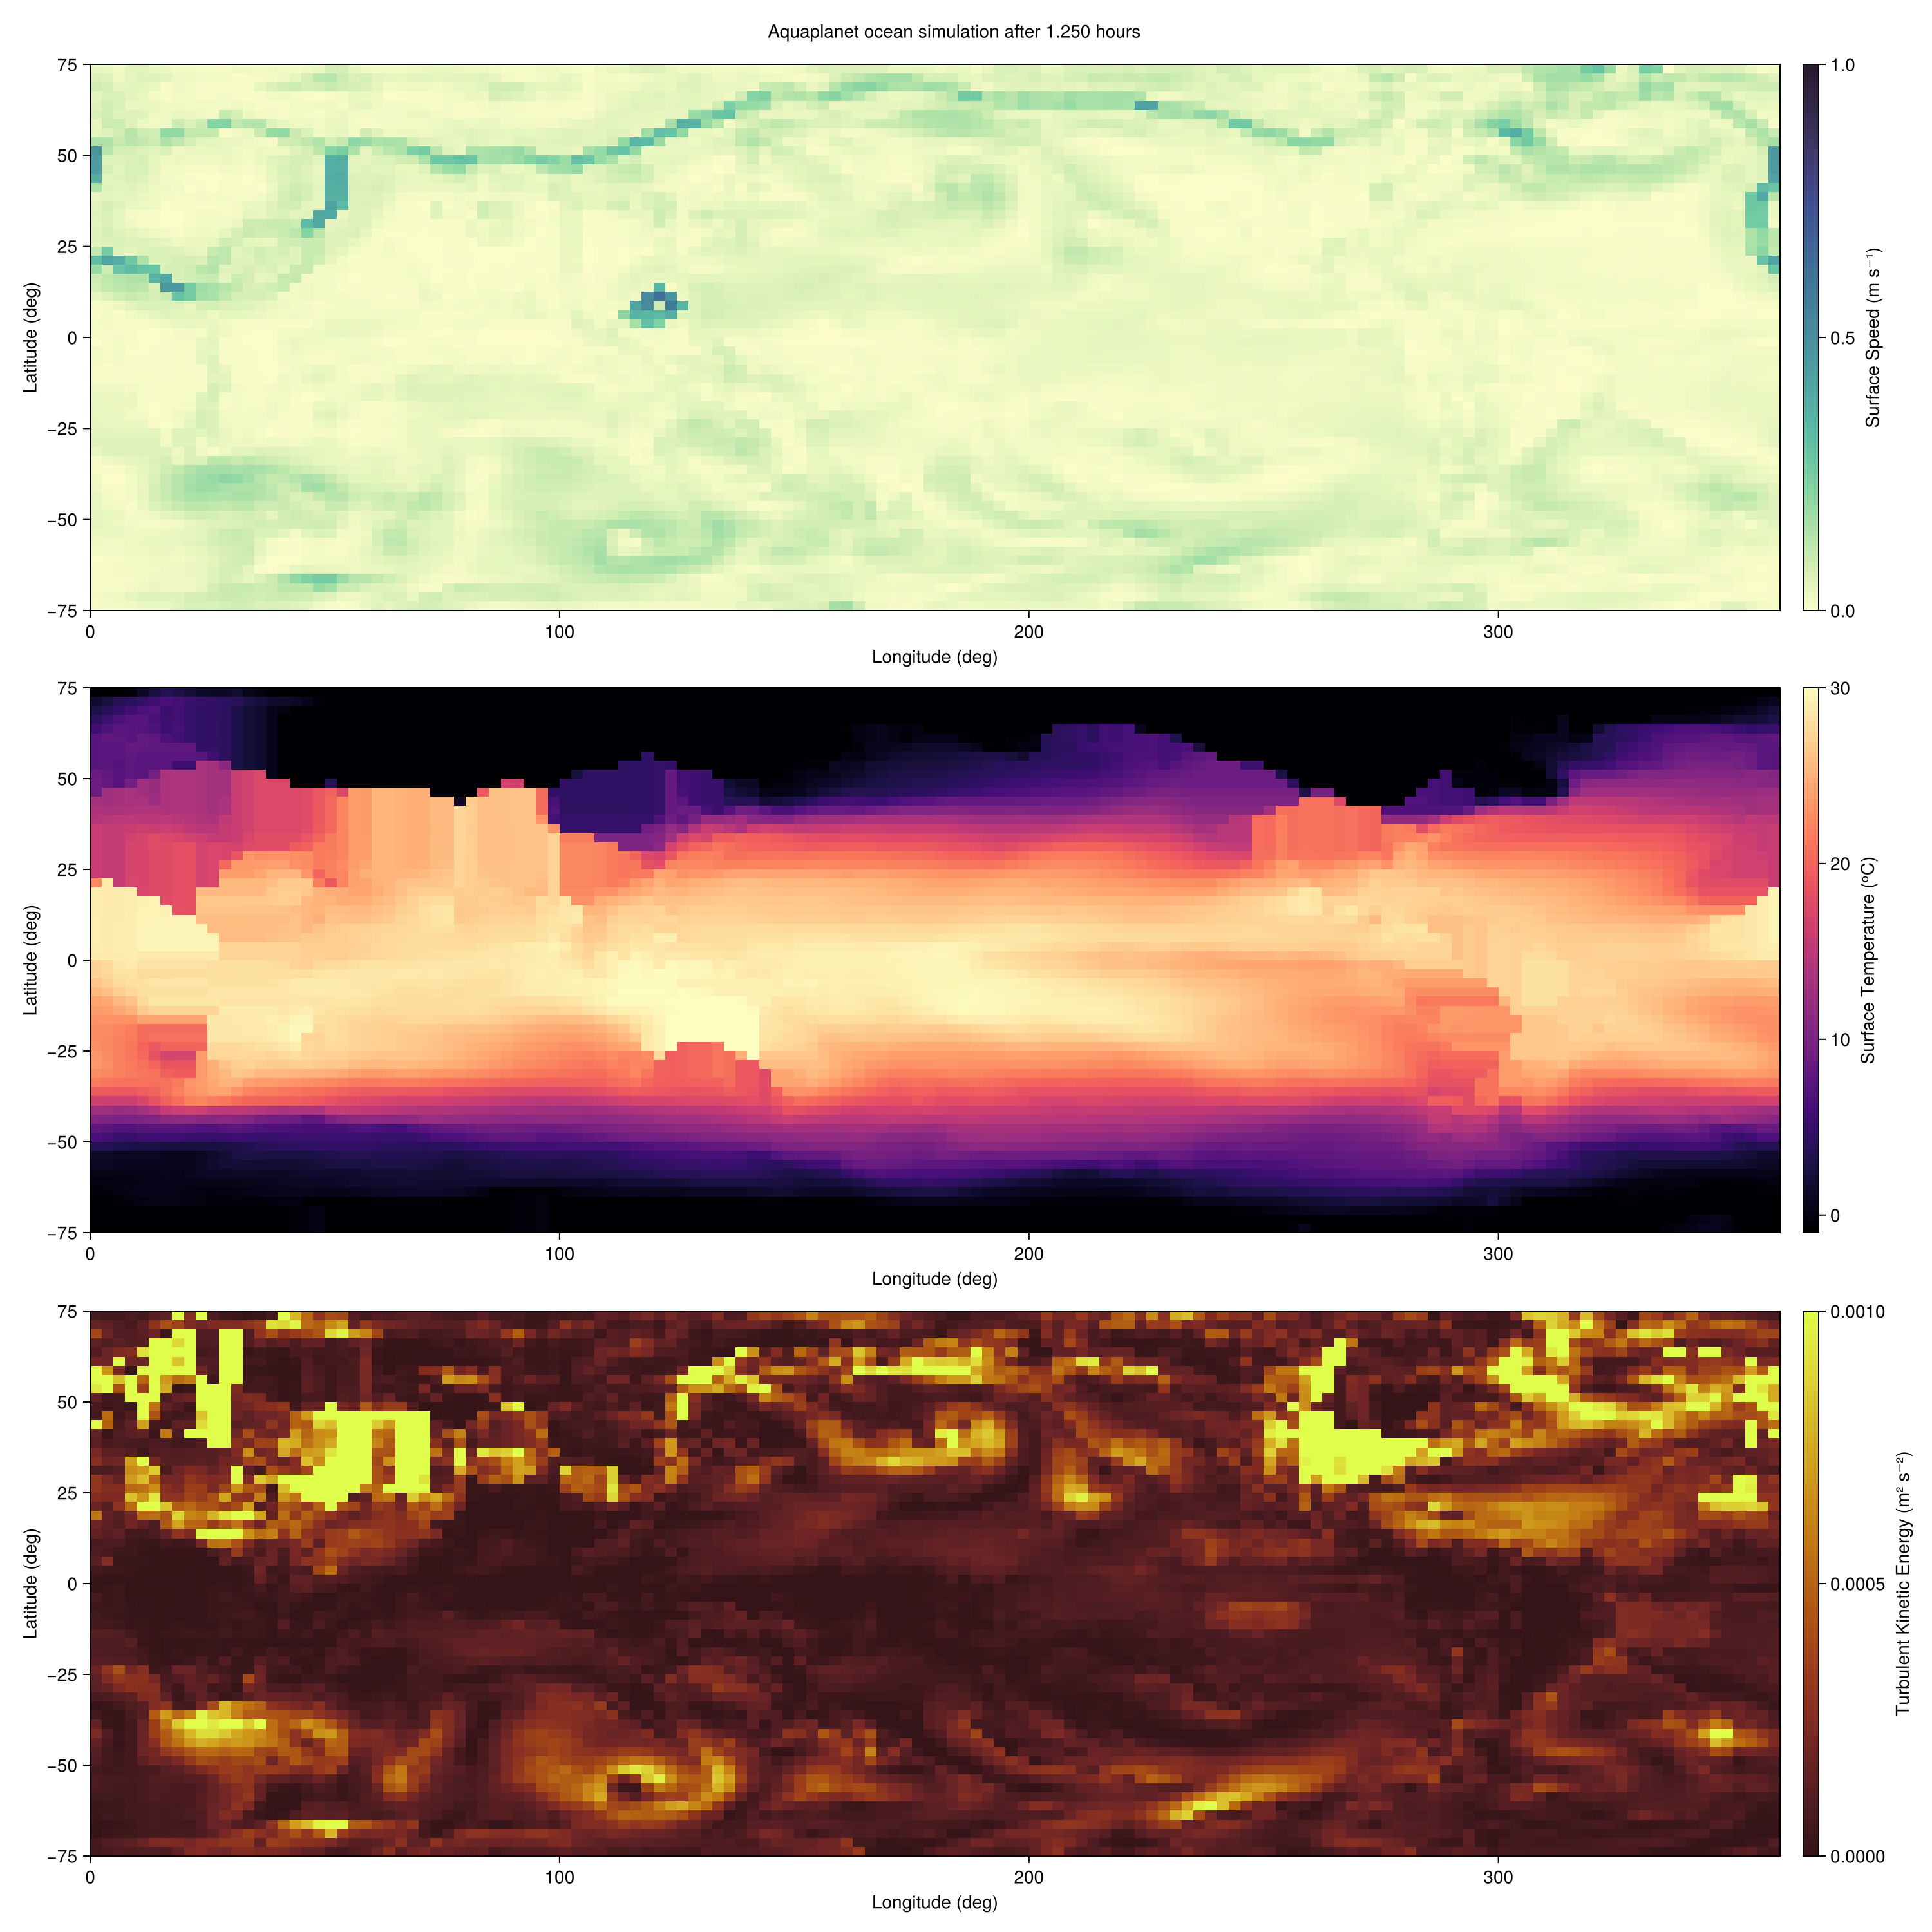

CairoMakie.Screen{IMAGE}


In [22]:
ybounds = nothing#(minimum(φ), -50)

fig = Figure(size = (1500, 1500))

axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")
axT = Axis(fig[2, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")
axe = Axis(fig[3, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

hm = heatmap!(axs, λ, φ, sn, colorrange = (0, 1), colormap = :deep, nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label = "Surface Speed (m s⁻¹)")

hm = heatmap!(axT, λ, φ, Tn, colorrange = (-1, 30), colormap = :magma, nan_color=:lightgray)
Colorbar(fig[2, 2], hm, label = "Surface Temperature (ᵒC)")

hm = heatmap!(axe, λ, φ, en, colorrange = (0, 1e-3), colormap = :solar, nan_color=:lightgray)
Colorbar(fig[3, 2], hm, label = "Turbulent Kinetic Energy (m² s⁻²)")

axs.limits = (nothing, ybounds) 
axT.limits = (nothing, ybounds) 
axe.limits = (nothing, ybounds)

Label(fig[0, :], title)
display(fig)

In [24]:
record(fig, "/g/data/v46/txs156/ClimaOcean.jl-checkpointer/"*"videos/aquaplanet_surface.mp4", 1:Nt, framerate = 8) do nn
    n[] = nn
end

"/g/data/v46/txs156/ClimaOcean.jl-checkpointer/videos/aquaplanet_surface.mp4"